<a href="https://colab.research.google.com/github/azuredge1101/deep-learn/blob/main/CBE109012%E6%9C%9F%E6%9C%AB(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **創造一個資料夾**

In [ ]:
image_dir = Path('/content/drive/MyDrive/archive/Fish_Dataset/Fish_Dataset')


filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')


image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Labels'].apply(lambda x: x[-2:] != 'GT')]


image_df = image_df.sample(frac=1).reset_index(drop = True)


image_df.head()

,Filepaths,Labels
0,/content/drive/MyDrive/archive/Fish_Dataset/Fi...,Red Sea Bream
1,/content/drive/MyDrive/archive/Fish_Dataset/Fi...,Shrimp
2,/content/drive/MyDrive/archive/Fish_Dataset/Fi...,Gilt-Head Bream
3,/content/drive/MyDrive/archive/Fish_Dataset/Fi...,Sea Bass
4,/content/drive/MyDrive/archive/Fish_Dataset/Fi...,Red Mullet


In [ ]:
!pip install dataprep
from dataprep.eda import create_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 18.1 MB/s 
     |████████████████████████████████| 1.0 MB 54.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.5 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 2.2 MB 70.1 MB/s 
     |████████████████████████████████| 133 kB 63.3 MB/s 
     |████████████████████████████████| 1.0 MB 51.2 MB/s 
     |████████████████████████████████| 764 kB 69.2 MB/s 
     |████████████████████████████████| 33.8 MB 1.4 MB/s 
     |████████████████████████████████| 1.3 MB 57.4 MB/s 
     |████████████████████████████████| 96 kB 7.2 MB/s 
     |████████████████████████████████| 232 kB 83.4 MB/s 
     |████████████████████████████████| 1.6 MB 69.1 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
     |████████████████████████████████| 133 kB 81.6 MB/s 
  Created wheel for metaphone: file

# **創建模型**

In [ ]:
import tensorflow as tf

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.85, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 6503 validated image filenames belonging to 9 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 1147 validated image filenames belonging to 9 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 1350 validated image filenames belonging to 9 classes.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [ ]:
input_shape = (224, 224, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_images, validation_data=val_images, epochs=6, callbacks=callback)

Epoch 1/6
102/102 [==============================] - 1885s 18s/step - loss: 1.3482 - accuracy: 0.4975 - val_loss: 0.4877 - val_accuracy: 0.8239
Epoch 2/6
102/102 [==============================] - 91s 897ms/step - loss: 0.4209 - accuracy: 0.8579 - val_loss: 0.2584 - val_accuracy: 0.9154
Epoch 3/6
102/102 [==============================] - 87s 850ms/step - loss: 0.1963 - accuracy: 0.9353 - val_loss: 0.2094 - val_accuracy: 0.9355
Epoch 4/6
102/102 [==============================] - 87s 858ms/step - loss: 0.1365 - accuracy: 0.9566 - val_loss: 0.1360 - val_accuracy: 0.9625
Epoch 5/6
102/102 [==============================] - 85s 837ms/step - loss: 0.0668 - accuracy: 0.9800 - val_loss: 0.1063 - val_accuracy: 0.9643
Epoch 6/6
102/102 [==============================] - 87s 849ms/step - loss: 0.0588 - accuracy: 0.9819 - val_loss: 0.1694 - val_accuracy: 0.9573


# **成果**

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

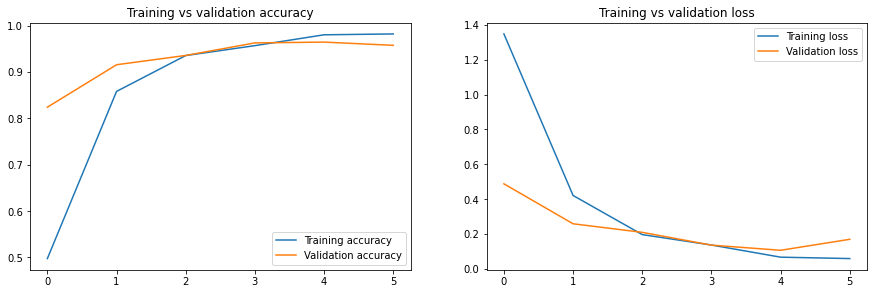

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [ ]:
results = model.evaluate(test_images, verbose = 0)

print("Test Loss {:.5f}".format(results[0]))
print("Test Accuracy {:.2f}%".format(results[1] * 100))

Test Loss 0.17020
Test Accuracy 95.26%


In [ ]:
model.evaluate(test_images)[1]

22/22 [==============================] - 15s 668ms/step - loss: 0.1702 - accuracy: 0.9526


0.9525926113128662